# Operations Department

#### Aim of the project: 

- The task is to automate the process of detecting and classifying chest diseases and overall reduce the cost and time of detection. 
- The data consists of extensive X-Ray chest data the goal is to develop a model that could detect and classify the diseases in less than a minute.
- The dataset has 133 images that belong to four major classes:
  - Healthy
  - Covid- 19
  - Bacterial Pneumonia
  - Viral Pneumonia


Resource References

- Kaggle Link: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
- GitHub Link: https://github.com/ieee8023/covid-chestxray-dataset


# Import Libraries and Dataset

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (
    Input,
    Add,
    Dense,
    Activation,
    ZeroPadding2D,
    BatchNormalization,
    Flatten,
    Conv2D,
    AveragePooling2D,
    MaxPooling2D,
    Dropout,
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler,
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2024-04-10 20:48:25.855425: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 20:48:25.859029: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:48:26.084601: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:48:27.524737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 20:48:32.191687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
import wandb
from wandb.keras import WandbMetricsLogger

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: debbarsha1503. Use `wandb login --relogin` to force relogin


True

In [3]:
# List the folders in the directory

X_Ray_Directory = "Dataset"
os.listdir(X_Ray_Directory)

['0', '1', '2', '3']

In [4]:
# Use image generator to generate tensor images  data and normalise them and use 20% of the data for cross-validation

image_generator = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

In [5]:
# Let's generate batches of 40 images
# Total number of images is 133*4 = 532 images.
# Training is 428 (80%) and validation is (20%).
# Perform shuffling and image resizing.

train_generator = image_generator.flow_from_directory(
    batch_size=40,
    directory=X_Ray_Directory,
    shuffle=True,
    target_size=(256, 256),
    class_mode="categorical",
    subset="training",
)

Found 428 images belonging to 4 classes.


In [6]:
validation_generator = image_generator.flow_from_directory(
    batch_size=40,
    directory=X_Ray_Directory,
    shuffle=True,
    target_size=(256, 256),
    class_mode="categorical",
    subset="validation",
)

Found 104 images belonging to 4 classes.


In [7]:
# Generate a batch of 40 images and lables.

train_images, train_lables = next(train_generator)
train_images.shape

(40, 256, 256, 3)

In [8]:
train_lables.shape

(40, 4)

In [9]:
train_lables

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]],

In [10]:
# Label translator

label_names = {
    0: "Covid-19",
    1: "Healthy",
    2: "Bacterial Pneumonia",
    3: "Viral Pneumonia",
}

# Data Exploration

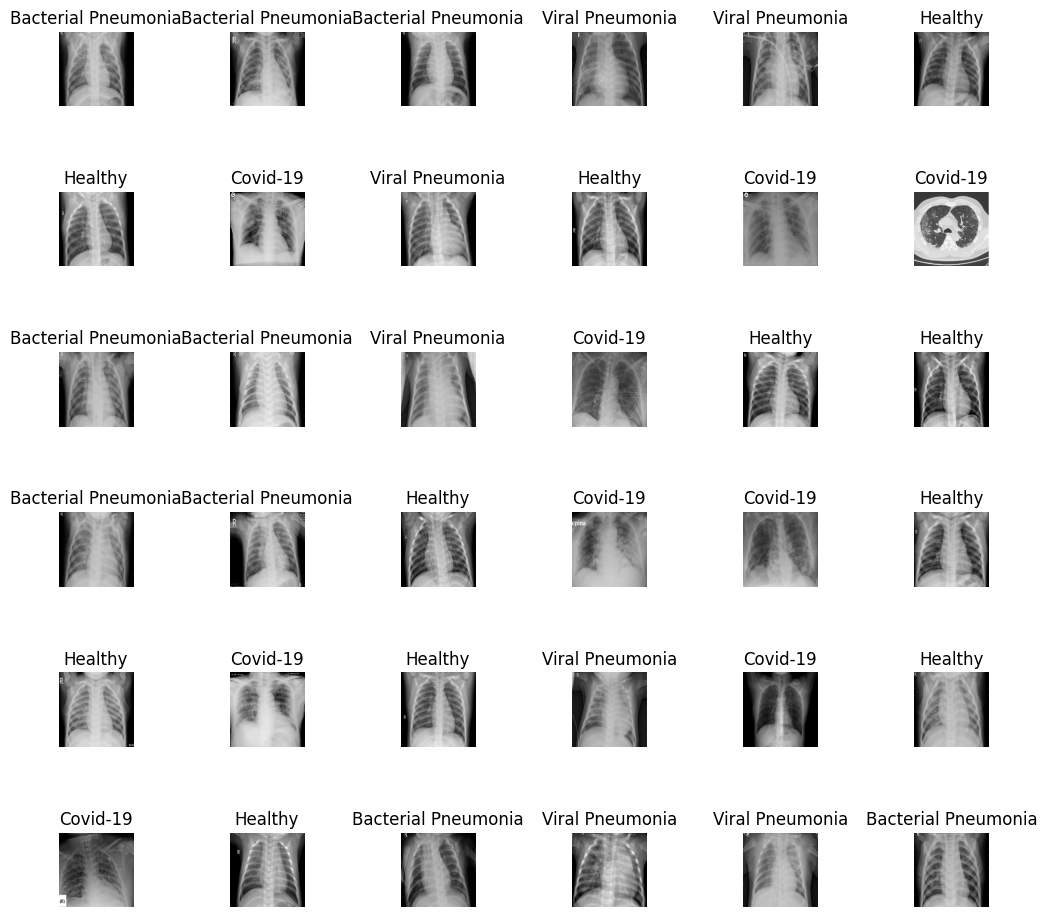

In [11]:
# Create a grid 6 rows and 6 columns.

L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()


for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_lables[i])])
    axes[i].axis("off")

plt.subplots_adjust(wspace=1.3, hspace=0.3)

In [12]:
# Import model with Pretrained weights.

basemodel = ResNet50V2(
    weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3))
)

In [13]:
basemodel.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 66, 66,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 64, 64,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [14]:
# Freeze the base model.

for layer in basemodel.layers[:-13]:
    layer.trainable = False

# Build and Train Deep Learning Model.

In [15]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation="softmax")(headmodel)

In [16]:
run = wandb.init(project="X-Ray-Chest-Disease-Detection")
wandb.config = {"epochs": 10, "learning_rate": 1e-4, "batch_size": 4}

In [17]:
model = Model(inputs=basemodel.input, outputs=headmodel)

In [18]:
# Lets compile the model.

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=wandb.config["learning_rate"]),
    metrics=["accuracy"],
)

In [19]:
# Using early stopping to exit training if validation loss does not improve for certain number of epochs (patience).

earlystopping = EarlyStopping(monitor="val_loss", mode="min", patience=20)

# Save the best model with lower validation loss.

checkpointer = ModelCheckpoint(filepath="weights.keras", verbose=1, save_best_only=True)

In [20]:
train_generator = image_generator.flow_from_directory(
    batch_size=wandb.config["batch_size"],
    directory=X_Ray_Directory,
    shuffle=True,
    target_size=(256, 256),
    class_mode="categorical",
    subset="training",
)
validation_generator = image_generator.flow_from_directory(
    batch_size=wandb.config["batch_size"],
    directory=X_Ray_Directory,
    shuffle=True,
    target_size=(256, 256),
    class_mode="categorical",
    subset="validation",
)

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [21]:
history = []
history = model.fit(
    train_generator,
    epochs=wandb.config["epochs"],
    validation_data=validation_generator,
    callbacks=[earlystopping, WandbMetricsLogger(), checkpointer],
)

Epoch 1/10


/home/barshadeb/.cache/pypoetry/virtualenvs/data_science_for_business_package-D-wAX5fy-py3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.4985 - loss: 1.1199

wandb: ERROR Unable to log learning rate.



Epoch 1: val_loss improved from inf to 0.40972, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 115s 979ms/step - accuracy: 0.5001 - loss: 1.1175 - val_accuracy: 0.8365 - val_loss: 0.4097
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9237 - loss: 0.3145
Epoch 2: val_loss did not improve from 0.40972
107/107 ━━━━━━━━━━━━━━━━━━━━ 94s 876ms/step - accuracy: 0.9237 - loss: 0.3146 - val_accuracy: 0.7981 - val_loss: 0.5498
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9319 - loss: 0.1473
Epoch 3: val_loss did not improve from 0.40972
107/107 ━━━━━━━━━━━━━━━━━━━━ 139s 853ms/step - accuracy: 0.9321 - loss: 0.1472 - val_accuracy: 0.8173 - val_loss: 0.5195
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9766 - loss: 0.0745
Epoch 4: val_loss did not improve from 0.40972
107/107 ━━━━━━━━━━━━━━━━━━━━ 144s 873ms/step - accuracy: 0.9767 - loss: 0.0743 - val_accuracy: 0.8558 - val_loss: 0.6562
Epoch 5/10
107/107 ━━━━━━━━━━━━━━

# Evaluate Trained Deep Learning model performance

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [23]:
wandb.log(
    {
        "train_performance": wandb.plot.line_series(
            xs=range(len(history.history["accuracy"])),
            ys=[history.history["accuracy"], history.history["loss"]],
            keys=["accuracy", "loss"],
            title="Train Accuracy and Loss",
            xname="Epoch",
        )
    }
)

In [24]:
test_directory = "Test"
test_gen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_gen.flow_from_directory(
    directory=test_directory,
    shuffle=True,
    target_size=(256, 256),
    batch_size=1,
    class_mode="categorical",
)

evaluate = model.evaluate(test_generator, verbose=1)
print("Accuracy Test: {}".format(evaluate[1]))
wandb.log({"Accuracy Test": round(evaluate[1], 3)})

Found 40 images belonging to 4 classes.
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.6807 - loss: 2.2943
Accuracy Test: 0.7749999761581421


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

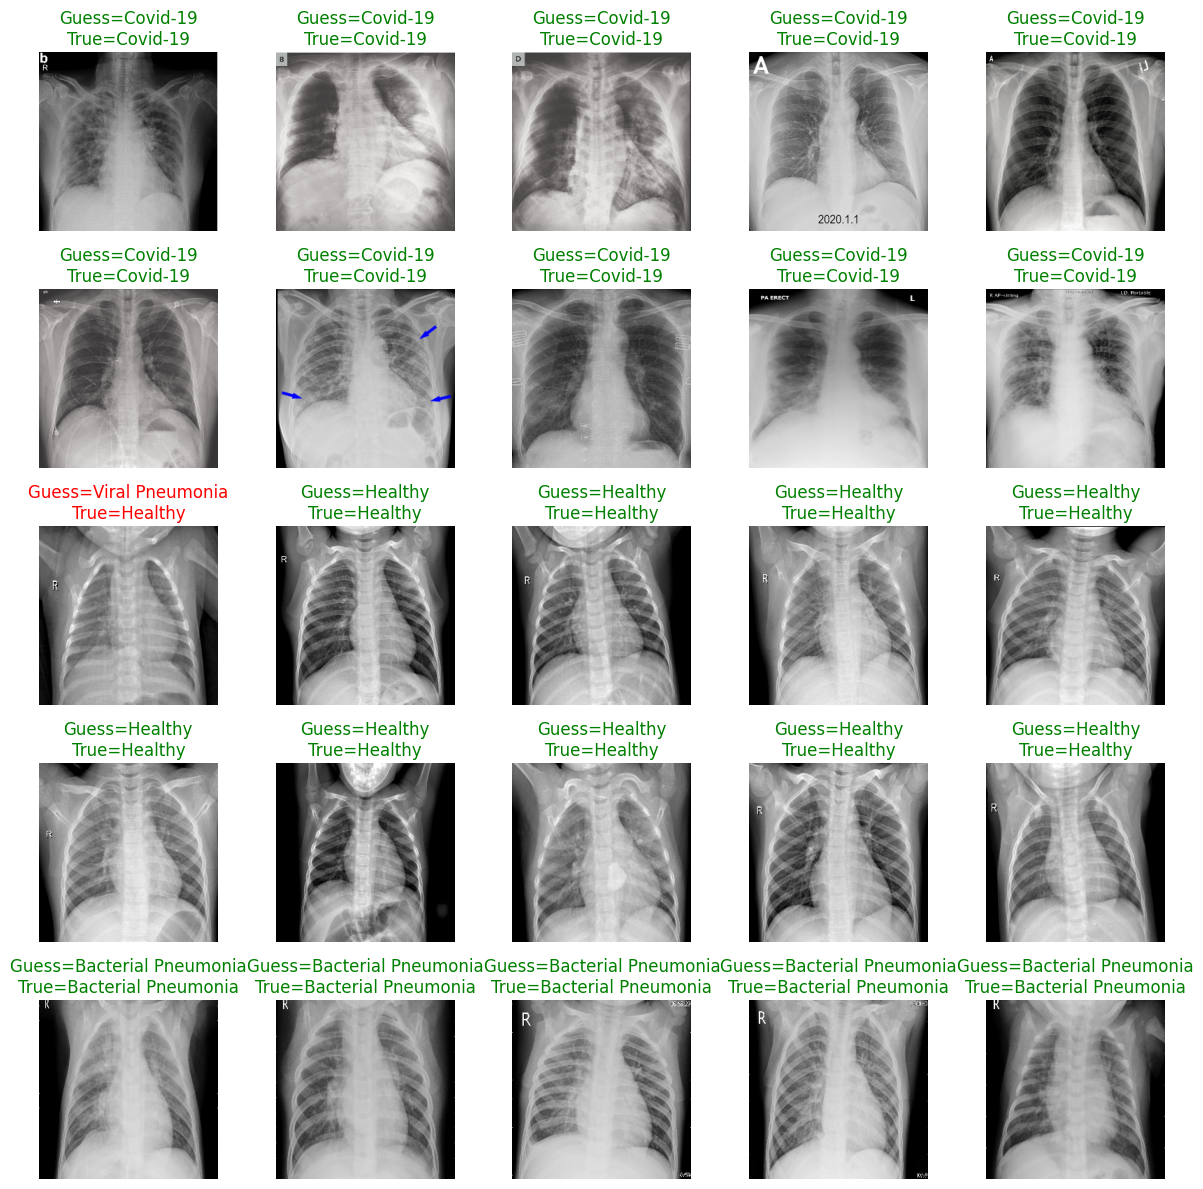

In [26]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(image[i])
    axes[i].set_title(
        "Guess={}\nTrue={}".format(
            str(label_names[prediction[i]]), str(label_names[original[i]])
        ),
        color="green" if prediction[i] == original[i] else "red",
    )
    axes[i].axis("off")

wandb.log({"Predictions": wandb.Image(fig)})

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.69      0.90      0.78        10
           2       0.71      0.50      0.59        10
           3       0.78      0.70      0.74        10

    accuracy                           0.78        40
   macro avg       0.77      0.77      0.77        40
weighted avg       0.77      0.78      0.77        40



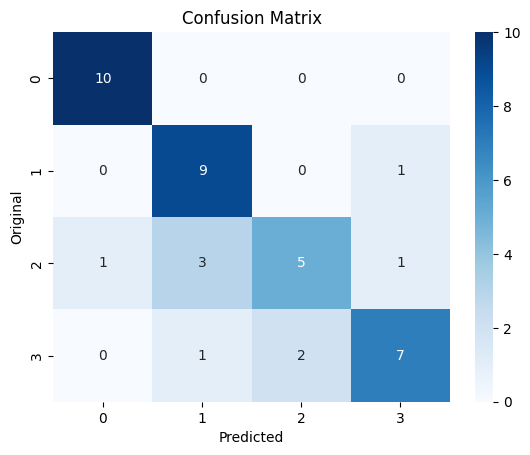

In [27]:
print(classification_report(np.asarray(original), np.array(prediction)))

# Weights and biases confusion matrix
cm = wandb.plot.confusion_matrix(
    y_true=original, preds=prediction, class_names=label_names
)

# Custom confusion seaborn matrix
cm = confusion_matrix(np.asarray(original), np.array(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel("Predicted")
ax.set_ylabel("Original")
ax.set_title("Confusion Matrix")

wandb.log({"Confusion Matrix": wandb.Image(ax)})

In [28]:
wandb.finish()

Accuracy Test,▁
epoch/accuracy,▁▆▇███████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▄▂▁▁▁▁▁▁▁
epoch/val_accuracy,▄▂▃▆█▇█▃▂▁
epoch/val_loss,▁▃▂▄▃▅▄███
Accuracy Test,0.775
epoch/accuracy,1.0
epoch/epoch,9
epoch/loss,0.00026
epoch/val_accuracy,0.78846
